In [5]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from transformer_lens import HookedTransformer, HookedTransformerConfig
import transformer_lens.utils as utils

from tree_generation import *
from utils import *
from interp_utils import *
from probing import *

Loading contents from file...


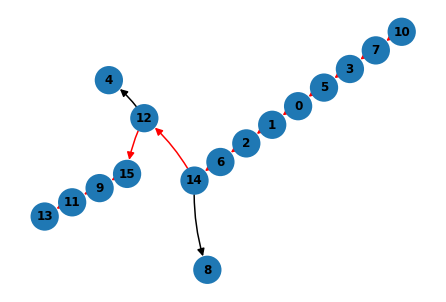

In [6]:
n_examples = 300_000
n_states = 16

dataset = GraphDataset(n_states, "dataset.txt", n_examples)
dataset.visualize_example(0)

In [7]:
cfg = HookedTransformerConfig(
    n_layers=6,
    d_model=128,
    n_ctx=dataset.max_seq_length - 1,
    n_heads=1,
    d_mlp=512,
    d_head=128,
    #attn_only=True,
    d_vocab=len(dataset.idx2tokens),
    device="cuda",
    attention_dir= "causal",
    act_fn="gelu",
)
model = HookedTransformer(cfg)


# Load in the model if weights are in the directory, else train new model
if os.path.exists("model_legacy.pt"):
    model.load_state_dict(torch.load("model_legacy.pt"))
else:
    train(model, train_loader, test_loader, n_epochs=100, learning_rate=3e-4)
    torch.save(model.state_dict(), "model_legacy.pt")

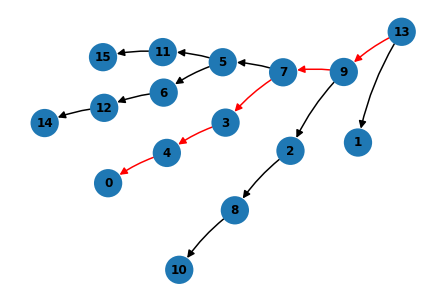

In [8]:
pred = generate_example(16, 0, order="backward", path_length=5)
if is_model_correct(model, dataset, pred):
    parse_example(pred)
cache = get_example_cache(pred, model, dataset)

In [9]:
act_names = ["blocks.1.ln2.hook_normalized", "blocks.2.ln2.hook_normalized", "blocks.3.ln2.hook_normalized", "blocks.4.ln2.hook_normalized", "blocks.5.ln2.hook_normalized", "ln_final.hook_normalized"]
model.reset_hooks()

if not os.path.exists("activations.pt"):
    print("Generating activations...")
    
    acts, graphs = aggregate_activations(
        model=model,
        dataset=dataset,
        activation_keys=act_names,
        n_samples=32_000,
        path_length=7,
        order="backward"
    )

    test_acts, test_graphs = aggregate_activations(
        model=model,
        dataset=dataset,
        activation_keys=act_names,
        n_samples=8_000,
        path_length=7,
        order="backward"
    )
    
    torch.save( (acts, graphs, test_acts, test_graphs) , "activations.pt")
else:
    acts, graphs, test_acts, test_graphs = torch.load("activations.pt")


In [10]:
def extract_transposed_adj_matrix(example_str, power=1):
    # Extract edgelist
    graph = example_str.split("|")[0]
    graph = graph.split(",")
    edgelist = []
    nodes = set()
    for e in graph:
        out_node = int(e.split(">")[0])
        in_node = int(e.split(">")[1])
        edgelist.append((out_node, in_node))
        nodes.add(out_node)
        nodes.add(in_node)
    # Extract path
    goal = example_str.split("|")[1]
    goal_node = int(goal.split(":")[0])
    path = goal.split(":")[1].split(">")
    path = [int(p) for p in path]
    path_edges = list(zip(path[:-1], path[1:]))
    # Make sure every edge in the path is valid
    for edge in path_edges:
        assert edge in edgelist
    # Create networkx graph
    G = nx.DiGraph()
    G.add_nodes_from(range(len(nodes)))
    for edge in edgelist:
        if edge in path_edges:
            color = "red"
        else:
            color = "black"
        G.add_edge(edge[0], edge[1], color=color)
    # Convert to numpy adjacency matrix
    adjacency_matrix_sparse = nx.adjacency_matrix(G)
    adjacency = adjacency_matrix_sparse.toarray().T
    if power is not None:
        ## Change all leaf nodes to self-loops
        row_sums = np.sum(adjacency, axis=1)
        for i in range(len(row_sums)):
            if row_sums[i] == 0:
                adjacency[i, i] = 1
        # Exponentiate matrix
        return np.linalg.matrix_power(adjacency, power)
    else:
        return adjacency

In [11]:


def return_probing_dataset(acts, graphs):
    X = {key: [] for key in acts.keys()}
    y = []
    for gidx, graph in enumerate(graphs):
        # Get output labels
        tokens = dataset.tokenize(graph)[:-1]
        start_idx = np.where(tokens == dataset.start_token)[0].item() + 2
        labels = [dataset.idx2tokens[idx] for idx in tokens]
        end_idx = num_last(labels, ",") + 1
        # Find neighboring nodes for each pos in edgelist
        path = [int(x.replace(">", "")) for x in labels[start_idx-1:end_idx-1]]
        path_arr = np.zeros((16,))
        path_arr[path] = 1.
        y.append(path_arr)
        # Iterate over all layers residual streams
        for key in X.keys():
            streams = acts[key][gidx][0, start_idx-1:start_idx]
            X[key].append(streams)
    # Convert everything to np arrays
    for key in X.keys():
        X[key] = torch.cat(X[key], dim=0).detach().cpu().numpy()
    y = np.array(y)
    return X, y


dataX, y = return_probing_dataset(acts, graphs)
dataXTest, y_test = return_probing_dataset(test_acts, test_graphs)

print(dataX["blocks.5.ln2.hook_normalized"].shape)
print(y.shape)

(31443, 128)
(31443, 16)


In [12]:
label = "blocks.5.ln2.hook_normalized"
X = dataX[label]
X_test = dataXTest[label]

In [23]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.neural_network import MLPRegressor



probe = MLPRegressor( max_iter=200, verbose=True)
probe.fit(X, y)
print(probe.score(X, y))

Iteration 1, loss = 0.12929657
Iteration 2, loss = 0.06411858
Iteration 3, loss = 0.04829762
Iteration 4, loss = 0.04128672
Iteration 5, loss = 0.03743829
Iteration 6, loss = 0.03498676
Iteration 7, loss = 0.03330517
Iteration 8, loss = 0.03225501
Iteration 9, loss = 0.03153043
Iteration 10, loss = 0.03090646
Iteration 11, loss = 0.03041217
Iteration 12, loss = 0.03003666
Iteration 13, loss = 0.02966191
Iteration 14, loss = 0.02927595
Iteration 15, loss = 0.02904281
Iteration 16, loss = 0.02878870
Iteration 17, loss = 0.02857187
Iteration 18, loss = 0.02830828
Iteration 19, loss = 0.02807176
Iteration 20, loss = 0.02788638
Iteration 21, loss = 0.02778241
Iteration 22, loss = 0.02753037
Iteration 23, loss = 0.02730023
Iteration 24, loss = 0.02713800
Iteration 25, loss = 0.02702277
Iteration 26, loss = 0.02682141
Iteration 27, loss = 0.02661074
Iteration 28, loss = 0.02644649
Iteration 29, loss = 0.02627603
Iteration 30, loss = 0.02606463
Iteration 31, loss = 0.02596649
Iteration 32, los

In [ ]:
from sparse_coding import SparseCoder

coder = SparseCoder(4096, verbose=True)
coder.fit(X)

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


probe = LinearRegression()
features = coder.featurize(X)
probe.fit(features, y)
print(probe.score(features,y))

answers = (probe.predict( coder.featurize(X_test) ) > 0)
y_pred = answers.flatten()
y_true = y_test.flatten()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print('Accuracy: {:.2f}%'.format(accuracy*100))
print('Precision: {:.2f}%'.format(precision*100))
print('Recall: {:.2f}%'.format(recall*100))


In [28]:
answers = (probe.predict(X_test) > 0.9)
y_pred = answers.flatten()
y_true = y_test.flatten()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print('Accuracy: {:.2f}%'.format(accuracy*100))
print('Precision: {:.2f}%'.format(precision*100))
print('Recall: {:.2f}%'.format(recall*100))

Accuracy: 83.24%
Precision: 99.94%
Recall: 66.51%


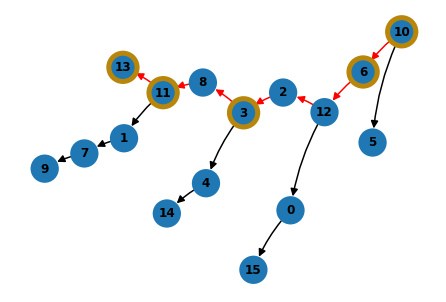

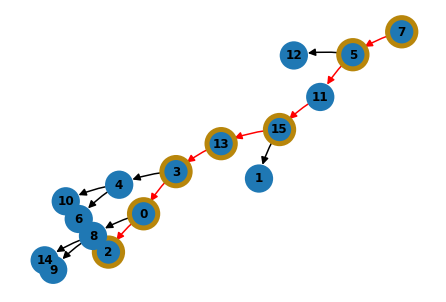

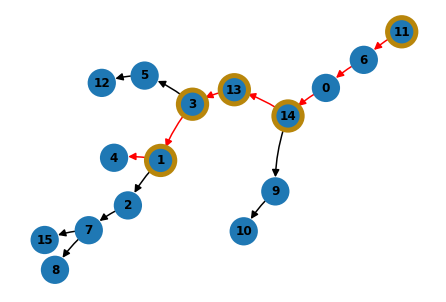

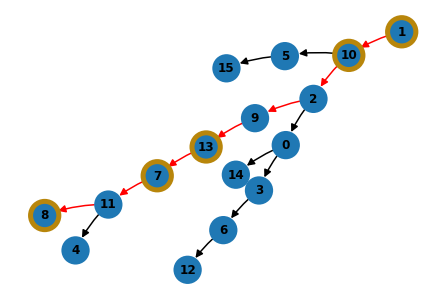

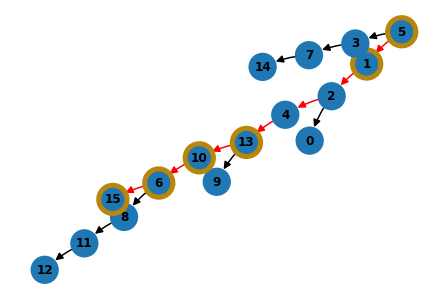

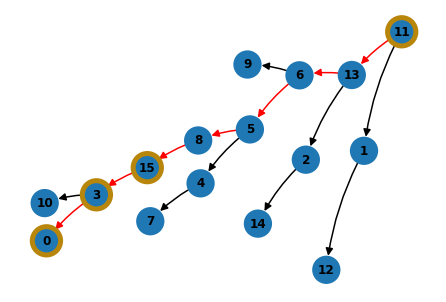

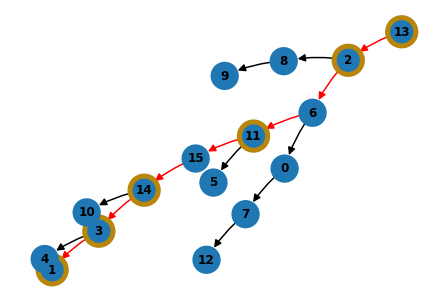

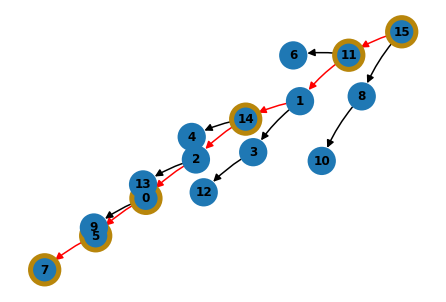

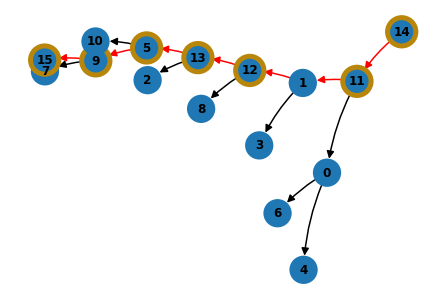

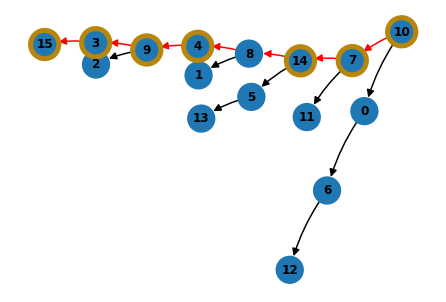

In [29]:

for test_example_idx in range(10):

    correct = np.where(y_pred[test_example_idx*16:(test_example_idx+1)*16])[0]
    parse_example(test_graphs[test_example_idx], highlight_nodes=correct.tolist())
    plt.show()

### Mor tests

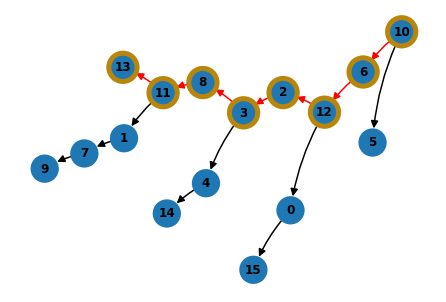

In [10]:
test_example_idx=0

correct = np.where(y_pred[test_example_idx*16:(test_example_idx+1)*16])[0]
parse_example(test_graphs[test_example_idx], highlight_nodes=correct.tolist())
plt.show()

In [11]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc = []

for i in range(2, 12):

    probe = MLPRegressor(hidden_layer_sizes=(2**i,), max_iter=200)
    probe.fit(X, y)
    print(probe.score(X,y))

    answers = (probe.predict(X_test) > 0)
    y_pred = answers.flatten()
    y_true = y_test.flatten()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    print('Accuracy: {:.2f}%'.format(accuracy*100))
    print('Precision: {:.2f}%'.format(precision*100))
    print('Recall: {:.2f}%'.format(recall*100))
    
    acc.append(accuracy*100)



0.21061295462129018


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:15                                                                                   │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'y_test' is not defined

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ c:\Users\abhay\Anaconda3\lib\site-packages\matplotlib\pyplot.py:2903 in semilogx                 │
│                                                                                                  │
│   2900 # Autogenerated by boilerplate.py.  Do not edit as changes will be lost.                  │
│   2901 @_copy_docstring_and_deprecators(Axes.semilogx)                                           │
│   2902 def semilogx(*args, **kwargs):                                                            │
│ ❱ 2903 │   return gca().semilogx(*args, **kwargs)                                                │
│   2904                                                                                           │
│   2905                                                                                           │
│   2906 # Autogenerated by boilerplate.py.  Do not edit as changes will be lost.                  │
│                                                                                                  │
│ c:\Users\abhay\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:1917 in semilogx             │
│                                                                                                  │
│   1914 │   │   │    if k in ['base', 'subs', 'nonpositive',                                      │
│   1915 │   │   │   │   │     'basex', 'subsx', 'nonposx']}                                       │
│   1916 │   │   self.set_xscale('log', **d)                                                       │
│ ❱ 1917 │   │   return self.plot(                                                                 │
│   1918 │   │   │   *args, **{k: v for k, v in kwargs.items() if k not in d})                     │
│   1919 │                                                                                         │
│   1920 │   # @_preprocess_data() # let 'plot' do the unpacking..                                 │
│                                                                                                  │
│ c:\Users\abhay\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:1743 in plot                 │
│                                                                                                  │
│   1740 │   │   (``'green'``) or hex strings (``'#008000'``).                                     │
│   1741 │   │   """                                                                               │
│   1742 │   │   kwargs = cbook.normalize_kwargs(kwargs, mlines.Line2D)                            │
│ ❱ 1743 │   │   lines = [*self._get_lines(*args, data=data, **kwargs)]                            │
│   1744 │   │   for line in lines:                                                                │
│   1745 │   │   │   self.add_line(line)                                                           │
│   1746 │   │   self._request_autoscale_view(scalex=scalex, scaley=scaley)                        │
│                                                                                                  │
│ c:\Users\abhay\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:273 in __call__              │
│                                                                                                  │
│    270 │   │   │   if args and isinstance(args[0], str):                                         │
│    271 │   │   │   │   this += args[0],                                                          │
│    272 │   │   │   │   args = args[1:]                                                           │
│ ❱  273 │   │   │   yield from self._plot_args(this, kwargs)                                      │
│    274 │                                                   

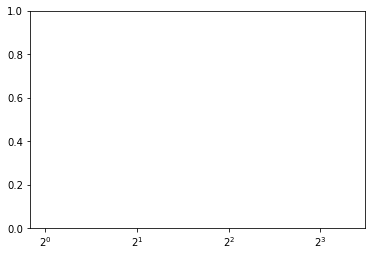

In [12]:
plt.semilogx([x**2 for x in range(1, 12)], acc, base=2)
plt.xlabel("MLP Hidden Dim")
plt.ylabel("Probe Accuracy")

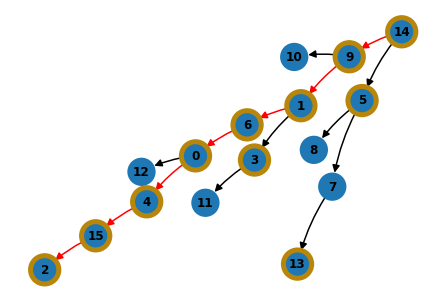

In [13]:
test_example_idx=100

correct = np.where(y_pred[test_example_idx*16:(test_example_idx+1)*16])[0]
parse_example(test_graphs[test_example_idx], highlight_nodes=correct.tolist())
plt.show()

### Sparse Coding Stuff

In [14]:
from sparse_coding import SparseCoder

coder = SparseCoder(8192, verbose=True)
coder.fit(X)

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


probe = LinearRegression()
features = coder.featurize(X)
probe.fit(features, y)
print(probe.score(features,y))

answers = (probe.predict( coder.featurize(X_test) ) > 0)
y_pred = answers.flatten()
y_true = y_test.flatten()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print('Accuracy: {:.2f}%'.format(accuracy*100))
print('Precision: {:.2f}%'.format(precision*100))
print('Recall: {:.2f}%'.format(recall*100))


Epoch 0 - Training Loss: 1052.1934 - Validation Loss: 3.9627
Epoch 1 - Training Loss: 13.0391 - Validation Loss: 0.9261
Epoch 2 - Training Loss: 5.7173 - Validation Loss: 0.7388
Epoch 3 - Training Loss: 4.7713 - Validation Loss: 0.6370
Epoch 4 - Training Loss: 4.2651 - Validation Loss: 0.5894
Epoch 5 - Training Loss: 3.9765 - Validation Loss: 0.5508
Epoch 6 - Training Loss: 3.7095 - Validation Loss: 0.5136
Epoch 7 - Training Loss: 3.4494 - Validation Loss: 0.4769
Epoch 8 - Training Loss: 3.1977 - Validation Loss: 0.4422
Epoch 9 - Training Loss: 2.9637 - Validation Loss: 0.4105
Epoch 10 - Training Loss: 2.7529 - Validation Loss: 0.3825
Epoch 11 - Training Loss: 2.5704 - Validation Loss: 0.3586
Epoch 12 - Training Loss: 2.4163 - Validation Loss: 0.3387
Epoch 13 - Training Loss: 2.2889 - Validation Loss: 0.3223
Epoch 14 - Training Loss: 2.1845 - Validation Loss: 0.3089
Epoch 15 - Training Loss: 2.0985 - Validation Loss: 0.2978
Epoch 16 - Training Loss: 2.0272 - Validation Loss: 0.2885
Epo

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:18                                                                                   │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'y_test' is not defined

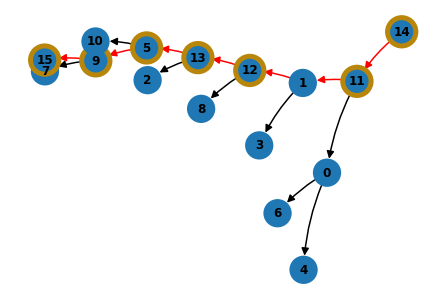

In [15]:
test_example_idx=8

correct = np.where(y_pred[test_example_idx*16:(test_example_idx+1)*16])[0]
parse_example(test_graphs[test_example_idx], highlight_nodes=correct.tolist())
plt.show()

### Other probing stuff


In [16]:
def return_probing_dataset(distance, acts, graphs):
    X = {key: [] for key in acts.keys()}
    y = []
    for gidx, graph in enumerate(graphs):
        # Get output labels
        tokens = dataset.tokenize(graph)[:-1]
        start_idx = np.where(tokens == dataset.start_token)[0].item() + 2
        labels = [dataset.idx2tokens[idx] for idx in tokens]
        end_idx = num_last(labels, ",")
        # Find neighboring nodes for each pos in edgelist
        path = [int(x.replace(">", "")) for x in labels[start_idx-1:start_idx] ]
        mat = extract_transposed_adj_matrix(graph, power=distance).argmax(-1)
        for node_i in range(dataset.n_states):
            y.append(mat[node_i])
            # Iterate over all layers residual streams
            for key in X.keys():
                if len(acts[key][gidx].shape) == 3:
                    streams = acts[key][gidx][0, start_idx-1:start_idx].cpu()
                elif len(acts[key][gidx].shape) == 4:
                    streams = acts[key][gidx][0, start_idx-1:start_idx, 0].cpu()
                streams = torch.cat([streams, torch.nn.functional.one_hot(torch.tensor(node_i), dataset.n_states)[None, :]], dim=1)
                X[key].append(streams)
    # Convert everything to np arrays
    for key in X.keys():
        X[key] = torch.cat(X[key], dim=0).detach().cpu().numpy()
    y = np.array(y)
    return X, y


In [17]:
X_test, y_test = return_probing_dataset(1, test_acts, test_graphs)

(array([5.6000e+02, 4.8480e+03, 1.4576e+04, 2.7456e+04, 3.4832e+04,
        2.8320e+04, 1.2848e+04, 2.3200e+03, 1.6000e+02, 1.6000e+01]),
 array([7.934502, 8.061827, 8.189152, 8.316476, 8.443801, 8.571125,
        8.69845 , 8.825774, 8.953099, 9.080423, 9.207748], dtype=float32),
 <BarContainer object of 10 artists>)

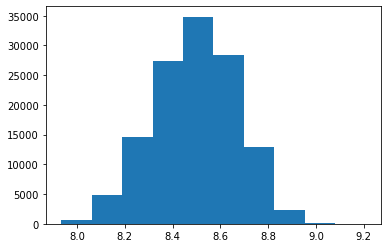

In [18]:
plt.hist(np.linalg.norm(X_test["blocks.4.ln2.hook_normalized"], axis=1))

In [19]:
probes = []

for depth in range(1, 8):
    X, y = return_probing_dataset(depth, acts, graphs)
    X_test, y_test = return_probing_dataset(depth, test_acts, test_graphs)

    print("=======================================")
    print(f"Distance {depth} results:")
    probe = NonlinearClsProbe(hidden_layer_sizes=(512,), max_iter=200, verbose=False)

    #X_temp = np.concatenate((X["blocks.4.attn.hook_z"], X["blocks.5.attn.hook_z"]), axis=1)
    X_temp = X["blocks.5.ln2.hook_normalized"]
    print(X_temp.shape)
    probe.fit(X_temp, y)
    print(probe.score(X_temp, y))

    #X_test_temp = np.concatenate((X_test["blocks.4.attn.hook_z"], X_test["blocks.4.attn.hook_z"]), axis=1)
    X_test_temp = X_test["blocks.5.ln2.hook_normalized"]

    answers = probe.predict(X_test_temp).numpy()
    y_pred = answers.flatten()
    y_true = y_test.flatten()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="macro")
    recall = recall_score(y_true, y_pred, average="macro")

    print('Accuracy: {:.2f}%'.format(accuracy*100))
    print('Precision: {:.2f}%'.format(precision*100))
    print('Recall: {:.2f}%'.format(recall*100))
    
    probes.append(probe)
    
    # Visualize which nodes the model copies over in the test examples
    for test_example_idx in range(1):
        correct = np.where(y_pred[test_example_idx*16:(test_example_idx+1)*16] == y_true[test_example_idx*16:(test_example_idx+1)*16])[0]
        parse_example(test_graphs[test_example_idx], highlight_nodes=correct.tolist())
        plt.show()

Distance 1 results:
(503088, 144)
